In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Data Encoding and Scaling
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [3]:
warnings.filterwarnings('ignore')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
# df = pd.read_csv('extracted_data1.csv')
df = pd.read_csv('test_data.csv')

In [6]:
df.shape

(6116, 32)

In [7]:
df.drop(['credit_amount',
         'subscription_type_y'], axis=1, inplace=True)

In [8]:
''' Filled all the null values before encoding the data '''

for col in df.columns:
    if df[col].dtype == np.int64:
        df[col].fillna(0, inplace=True)
    elif df[col].dtype == np.float64:
        df[col].fillna(0.0, inplace=True)
    elif df[col].dtype == object:
        unique_vals = df[col].dropna().unique()
        if set(unique_vals).issubset({'Yes', 'No'}):
            df[col].fillna('No', inplace=True)
        else:
            df[col].fillna('Unknown', inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   jobma_catcher_id               6116 non-null   int64  
 1   org_type                       6116 non-null   float64
 2   jobma_catcher_industry         6116 non-null   object 
 3   jobma_catcher_type             6116 non-null   int64  
 4   is_premium                     6116 non-null   float64
 5   jobma_catcher_sub_accounts     6116 non-null   int64  
 6   jobma_catcher_is_deleted       6116 non-null   object 
 7   jobma_verified                 6116 non-null   int64  
 8   subscription_status            6116 non-null   int64  
 9   interview_rate                 6116 non-null   float64
 10  live_interview_credit          6116 non-null   float64
 11  pre_recorded_credit            6116 non-null   float64
 12  credit_value                   6116 non-null   i

In [10]:
''' This Function is to fill all missing values (if col is int then 0, if col is float then 0.0 and if col is object then 'Unkmown') '''

def fill_missing_values(df):
    df = df.copy()
    if df[col].dtype == np.int64:
        df[col].fillna(0, inplace=True)
    elif df[col].dtype == np.float64:
        df[col].fillna(0.0, inplace=True)
    elif df[col].dtype == object:
        unique_vals = df[col].dropna().unique()
        if set(unique_vals).issubset({'Yes', 'No'}):
            df[col].fillna('No', inplace=True)
        else:
            df[col].fillna('Unknown', inplace=True)
    return df

# Data Encoding

In [12]:
label_encoders = {}
label_col = ['jobma_catcher_industry', 'org_type']

def label_encoder(df):
    for col in label_col:
        if col in df.columns:
            if df[col].dtype == object or df[col].dtype.name == 'category':
                le_col = LabelEncoder()
                df[col] = le_col.fit_transform(df[col].astype(str))
                label_encoders = le_col

    return df

In [13]:
def ordinal_encoder(df):
    ordinal_col = ['jobma_catcher_is_deleted', 'company_size', 'plan_type', 'is_unlimited']
    
    is_deleted_order = ['Yes', 'No']
    company_size_order = ['Unknown', '1-25', '26-100', '101-500', '500-1000', 'More than 1000']
    plan_type_order = ['Unknown', 'No', 'Yes']
    is_unlimited_order = ['Unknown', 'No', 'Yes']

    ordinal_order = [is_deleted_order, company_size_order, plan_type_order, is_unlimited_order]

    ordinal = OrdinalEncoder(categories=ordinal_order)
    encoded = ordinal.fit_transform(df[ordinal_col].astype(str))
    encoded_df = pd.DataFrame(encoded, columns=[f'{col}_ord' for col in ordinal_col], index=df.index)

    df.drop(columns=ordinal_col, inplace=True)

    df = pd.concat([df, encoded_df], axis=1)
    
    return df

# Log Transformation

In [15]:
log_cols = [
    'wallet_amount',
    'subscription_amount',
    'number_of_invitations',
    'job_posted',
    'number_of_kits',
    'interview_question',
    'pre_recorded_credit',
    'live_interview_credit'
]

In [16]:
def log_transform(df):
    df = df.copy()
    for col in log_cols:
        if col in df.columns:
            # fill NaNs
            df[col] = df[col].fillna(0)
            # if a number is less than zero, turn it into zero;
            df[col] = df[col].clip(lower=0)
            # safe log1p
            df[col] = np.log1p(df[col])
    return df

# Pipeline

In [18]:
pipeline = Pipeline([
    ('fill_missing_values', FunctionTransformer(fill_missing_values, validate=False)),
    ('label_encoder', FunctionTransformer(label_encoder, validate=False)),
    ('ordinal_encoder', FunctionTransformer(ordinal_encoder, validate=False)),
    ('log_transformation', FunctionTransformer(log_transform, validate=False)), # log transforms the col with outliers
    ('scaler', StandardScaler()), # Needs attention to improve model
    # ('pca', PCA(n_components=0.97))
])

In [19]:
''' Visualizing the Pipeline '''
set_config(display='diagram')
pipeline

Pipeline(steps=[('fill_missing_values',
                 FunctionTransformer(func=<function fill_missing_values at 0x000001D597378400>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x000001D5973789A0>)),
                ('ordinal_encoder',
                 FunctionTransformer(func=<function ordinal_encoder at 0x000001D597378C20>)),
                ('log_transformation',
                 FunctionTransformer(func=<function log_transform at 0x000001D5973799E0>)),
                ('scaler', StandardScaler())])

# Fit Pipeline

In [21]:
X = df

In [22]:
X_transformed = pipeline.fit_transform(X)

In [23]:
type(X)

pandas.core.frame.DataFrame

In [24]:
type(X_transformed)

numpy.ndarray

In [25]:
features_names = df.columns

In [26]:
X_df = pd.DataFrame(X_transformed)

In [27]:
X_df.columns

RangeIndex(start=0, stop=30, step=1)

In [28]:
X_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-1.801958,-0.324121,0.485709,0.66236,-0.438409,0.0,0.018086,-1.092955,0.0,0.130641,...,0.0,1.136717,-0.176975,1.321832,0.853812,1.585420,0.0,-0.989747,-0.711360,2.504455
1,-1.673482,-0.324121,-1.162534,0.66236,-0.438409,0.0,0.018086,0.904210,0.0,0.130641,...,0.0,-0.234210,-0.176975,-0.372727,-0.383732,-0.385895,0.0,-0.111057,1.405758,-0.399288
2,-1.672561,-0.324121,0.140979,0.66236,-0.438409,0.0,0.018086,0.904210,0.0,0.130641,...,0.0,-0.042089,-0.176975,-0.372727,-0.383732,-0.385895,0.0,0.767632,1.405758,-0.399288
3,-1.672101,-0.324121,-1.539583,0.66236,-0.438409,0.0,0.018086,-1.092955,0.0,0.130641,...,0.0,1.139948,0.472322,-0.372727,0.853812,-0.385895,0.0,-0.111057,1.405758,-0.399288
4,-1.671640,-0.324121,-1.474946,0.66236,-0.438409,0.0,0.018086,0.904210,0.0,0.130641,...,0.0,1.078241,-0.176975,-0.372727,0.853812,-0.385895,0.0,-0.111057,1.405758,-0.399288


In [29]:
X_df.shape

(6116, 30)

In [30]:
X_df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,6116.0,-1.487074e-16,1.000082,-1.801958,-0.845184,-0.033923,0.723001,1.826670
1,6116.0,9.294215e-18,1.000082,-0.324121,-0.324121,-0.324121,-0.324121,4.558455
2,6116.0,-7.725816e-17,1.000082,-2.078224,-0.882440,0.302571,1.153624,1.175170
3,6116.0,1.115306e-16,1.000082,-1.509754,-1.509754,0.662360,0.662360,0.662360
4,6116.0,0.000000e+00,1.000082,-0.438409,-0.438409,-0.438409,-0.438409,2.280973
5,6116.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6116.0,2.681381e-15,1.000082,-55.290144,0.018086,0.018086,0.018086,0.018086
7,6116.0,2.230612e-16,1.000082,-3.090120,-1.092955,0.904210,0.904210,0.904210
8,6116.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,6116.0,-3.392388e-16,1.000082,-5.733589,0.130641,0.130641,0.130641,15.289454


In [31]:
# df['is_unlimited'].unique()

In [32]:
X_tensor = torch.tensor(X_transformed, dtype=torch.float32).to(device)

In [33]:
type(X_tensor)

torch.Tensor

In [34]:
len(X_tensor)

6116

# Dataset Class

In [36]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [37]:
X_data = CustomDataset(X_tensor)

# DataLoader

In [39]:
BATCH_SIZE = 8

In [40]:
dataloader = DataLoader(X_data, batch_size=BATCH_SIZE, shuffle=False)

In [41]:
len(X_data)

6116

In [42]:
len(dataloader)

765

# Autoencoder

In [44]:
class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        ''' Encoder (Compression) '''
        # Shrinks job data into a small hidden representation (like a summary).
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        ''' Decoder (Reconstruction) '''
        # Tries to rebuild the original job data from that compressed version.
        self.decoder = nn.Sequential(
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, input_shape)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

**FLOW 1**

Model's encoder(embeddings) ----->  DEC's Input1

In [46]:
X_df.shape[1]

30

In [47]:
''' Initializing the model '''
input_shape = X_df.shape[1]

model_1 = AutoEncoder(input_shape)
model_1.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=30, bias=True)
  )
)

In [48]:
''' Important Parameters '''

learning_rate = 1e-4
epochs = 20

In [49]:
''' Loss Function and Optimizer '''

# cosine_loss_function = nn.CosineEmbeddingLoss()
mse_loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(model_1.parameters(), lr=learning_rate, weight_decay=1e-5)
# LR Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [50]:
torch.manual_seed(42)

model_1.train()
model_1.to(device)

# Early Stopping Setup
best_loss = float('inf')
patience = 5
trigger_times = 0

for epoch in range(epochs):
    epoch_total_loss = 0

    for batch_X in dataloader:
        batch_X = batch_X.to(device)

        # Forward pass
        encoded, decoded = model_1(batch_X)

        # Reconstruction Loss
        mse_loss = mse_loss_function(decoded, batch_X)

        # Backpropagation
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()

        epoch_total_loss += mse_loss.item()

    # Average loss over all batches in the epoch
    training_loss = epoch_total_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{epochs} | Training Loss: {training_loss:.5f}')

    # Early Stopping logic
    if training_loss < best_loss:
        best_loss = training_loss
        trigger_times = 0
        torch.save(model_1.state_dict(), "best_autoencoder.pth")  # Save best model
    else:
        trigger_times += 1
        print(f"Early stopping trigger: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping activated.")
            break

    scheduler.step()  # Step the LR scheduler

Epoch 1/20 | Training Loss: 0.62250
Epoch 2/20 | Training Loss: 0.44299
Epoch 3/20 | Training Loss: 0.33721
Epoch 4/20 | Training Loss: 0.28350
Epoch 5/20 | Training Loss: 0.25543
Epoch 6/20 | Training Loss: 0.23105
Epoch 7/20 | Training Loss: 0.21047
Epoch 8/20 | Training Loss: 0.19386
Epoch 9/20 | Training Loss: 0.17896
Epoch 10/20 | Training Loss: 0.16421
Epoch 11/20 | Training Loss: 0.15145
Epoch 12/20 | Training Loss: 0.14243
Epoch 13/20 | Training Loss: 0.13525
Epoch 14/20 | Training Loss: 0.12855
Epoch 15/20 | Training Loss: 0.12223
Epoch 16/20 | Training Loss: 0.11682
Epoch 17/20 | Training Loss: 0.11113
Epoch 18/20 | Training Loss: 0.10613
Epoch 19/20 | Training Loss: 0.10091
Epoch 20/20 | Training Loss: 0.09610


# Clustering

In [52]:
model_1.eval()

with torch.no_grad():
    encoder, _ = model_1(X_tensor)

latent_np = encoder.cpu().numpy()

In [53]:
wcss = []
silhouette_scores = []
k_range = range(2,11)

In [54]:
torch.manual_seed(42)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(latent_np)
    
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(latent_np, labels))

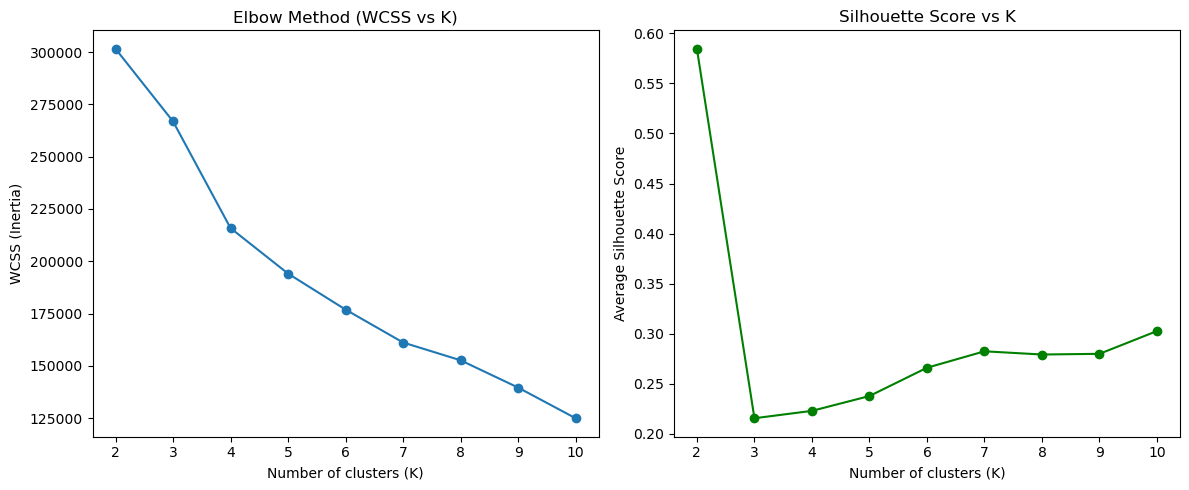

In [55]:
''' Elbow Rule to decide the number of clusters '''
torch.manual_seed(42)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method (WCSS vs K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')

# Step 5: Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Average Silhouette Score')

plt.tight_layout()
plt.show()

In [57]:
#Initialising KMeans
kmeans = KMeans(n_clusters=3, n_init=50, init='k-means++', random_state=42)
cluster_ids = kmeans.fit_predict(latent_np)
cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

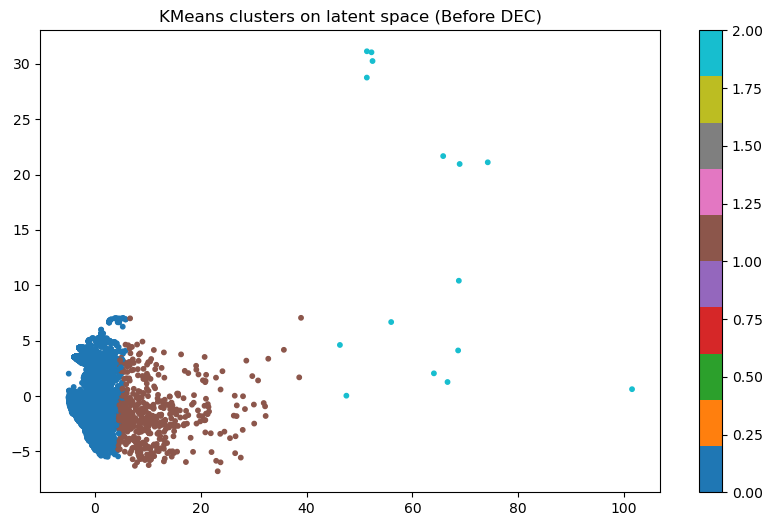

In [59]:
latent_2d = PCA(n_components=2).fit_transform(latent_np)
plt.figure(figsize=(10, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_ids, cmap='tab10', s=10)
plt.title("KMeans clusters on latent space (Before DEC)")
plt.colorbar()
plt.show()

**FLOW 2**

KMeans Cluster_Centers(Centroids) ----->  DEC's Input2

In [61]:
# Deep Embedding Clusturing Model
class DEC(nn.Module):
    def __init__(self, encoder, cluster_centers):
        super(DEC, self).__init__()
        self.encoder = encoder
        self.cluster_centers = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, dim=2))
        q = q.pow((1 + 1) / 2.0)
        q = (q.t() / torch.sum(q, dim=1)).t()
        return q, z

def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()  

In [63]:
''' Initializing DEC Model '''
dec = DEC(model_1.encoder, cluster_centers.clone()).to(device)

In [65]:
''' Loss Function and Optimizer '''

kl_loss = nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(dec.parameters(), lr=5e-4)
batch_size = dataloader.batch_size

In [ ]:
# ''' Training Loop '''
# torch.manual_seed(42)
# dec.train()
# num_epochs = 50

# for epoch in range(num_epochs):
#     for batch in dataloader:
#         x = batch.to(device)

#         # Forward pass
#         q, z = dec(x)

#         # Target distribution
#         p = target_distribution(q)

#         # Compute loss
#         loss = kl_loss(q.log(), p)

#         # Backpropogation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

In [67]:
dec.train()
num_epochs = 50
for epoch in range(num_epochs):
    # Compute global soft assignments q_all
    with torch.no_grad():
        q_all, _ = dec(X_tensor.to(device))            
        p_all = target_distribution(q_all)              

    epoch_loss = 0.0
    for batch_idx, batch in enumerate(dataloader):
        x = batch.to(device)
        q_batch, _ = dec(x)                            

        # Slice the matching rows from p_all
        start = batch_idx * batch_size
        end   = start + x.size(0)
        p_batch = p_all[start:end].to(device)          

        # Compute loss against the global target
        loss = kl_loss(torch.log(q_batch + 1e-8), p_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x.size(0)

    avg_loss = epoch_loss / len(X_tensor)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg KL Loss: {avg_loss:.4f}")

Epoch 1/50, Avg KL Loss: 0.0085
Epoch 2/50, Avg KL Loss: 0.0163
Epoch 3/50, Avg KL Loss: 0.0260
Epoch 4/50, Avg KL Loss: 0.0293
Epoch 5/50, Avg KL Loss: 0.0326
Epoch 6/50, Avg KL Loss: 0.0345
Epoch 7/50, Avg KL Loss: 0.0353
Epoch 8/50, Avg KL Loss: 0.0360
Epoch 9/50, Avg KL Loss: 0.0368
Epoch 10/50, Avg KL Loss: 0.0364
Epoch 11/50, Avg KL Loss: 0.0354
Epoch 12/50, Avg KL Loss: 0.0344
Epoch 13/50, Avg KL Loss: 0.0335
Epoch 14/50, Avg KL Loss: 0.0319
Epoch 15/50, Avg KL Loss: 0.0307
Epoch 16/50, Avg KL Loss: 0.0297
Epoch 17/50, Avg KL Loss: 0.0288
Epoch 18/50, Avg KL Loss: 0.0281
Epoch 19/50, Avg KL Loss: 0.0272
Epoch 20/50, Avg KL Loss: 0.0266
Epoch 21/50, Avg KL Loss: 0.0260
Epoch 22/50, Avg KL Loss: 0.0255
Epoch 23/50, Avg KL Loss: 0.0252
Epoch 24/50, Avg KL Loss: 0.0250
Epoch 25/50, Avg KL Loss: 0.0241
Epoch 26/50, Avg KL Loss: 0.0233
Epoch 27/50, Avg KL Loss: 0.0220
Epoch 28/50, Avg KL Loss: 0.0209
Epoch 29/50, Avg KL Loss: 0.0197
Epoch 30/50, Avg KL Loss: 0.0186
Epoch 31/50, Avg KL

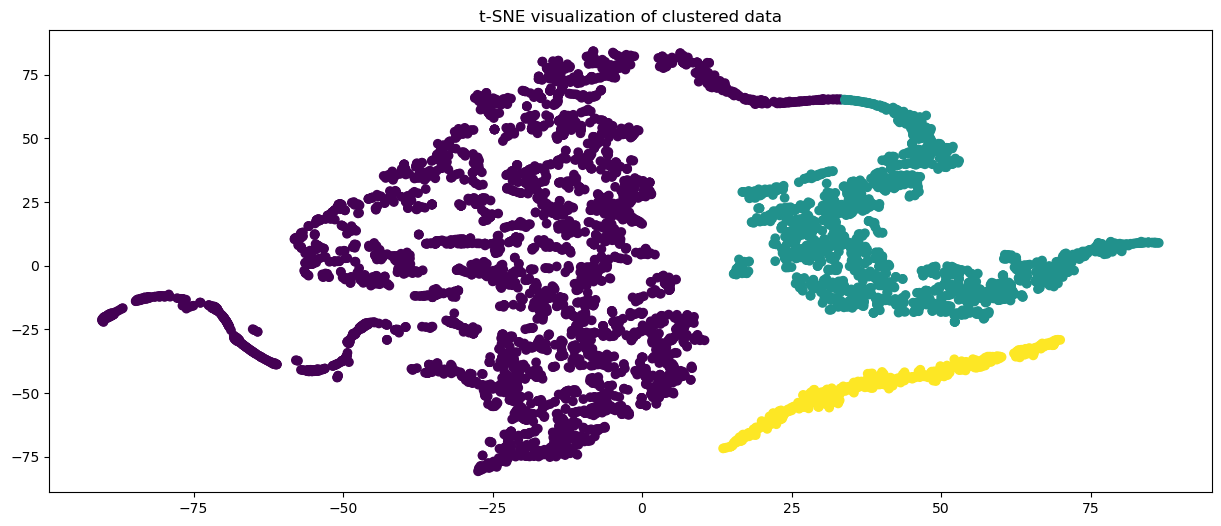

In [106]:
''' Visualizing the Clusters '''

dec.eval()

with torch.no_grad():
    q, _ = dec(X_tensor.to(device))  # Get cluster assignments
    preds = torch.argmax(q, dim=1).cpu().numpy()

with torch.no_grad():
    _, z= dec(X_tensor.to(device)) # Get embedded features
    # Reduce dimensions for visualization (using t-SNE)
    z_2d = TSNE(n_components=2).fit_transform(z.cpu().numpy())

    # Visualize the clusters (color = cluster assignments)
    plt.figure(figsize=(15,6))
    plt.scatter(z_2d[:,0], z_2d[:,1], c=preds, cmap='viridis')
    plt.title('t-SNE visualization of clustered data')
    plt.show()

In [69]:
''' Add cluster labels to original dataframe '''
df_train = df.iloc[-X_tensor.shape[0]:].copy()
df_train['cluster_id'] = preds

In [70]:
cluster_summary = df_train.groupby('cluster_id').mean(numeric_only=True)
cluster_summary

,jobma_catcher_id,org_type,jobma_catcher_type,is_premium,jobma_catcher_sub_accounts,jobma_verified,subscription_status,interview_rate,live_interview_credit,pre_recorded_credit,...,video_recording_suppport,sing_up_canditate_after_apply,currency,wallet_amount,premium_storage,subscription_amount,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,5913.729682,0.009752,0.619905,0.156539,0.0,0.9995,1.626407,0.0,1.000000,1.000000,...,2.0,0.0,0.427107,43.092023,0.0,53277.681135,0.958490,0.360090,0.150038,0.087522
1,7713.235723,0.397934,0.799514,0.114216,0.0,1.0000,1.430741,0.0,0.910085,0.959295,...,2.0,0.0,0.405832,19885.261239,0.0,38241.494484,1.736938,3.919806,0.713852,0.571689
2,8135.961783,0.250531,0.968153,0.365180,0.0,1.0000,1.282378,0.0,1.091295,27.511656,...,2.0,0.0,0.333333,60444.815287,0.0,425601.896327,5.855626,163.055202,6.970276,9.133758


In [71]:
unique_clusters = np.unique(preds)
print(f"Unique Clusters Found: {len(unique_clusters)} -> {unique_clusters}")

Unique Clusters Found: 3 -> [0 1 2]


# Final Step: Add Meaningful Cluster Labels for Recommendation System

In [72]:
cluster_names = {
    0: "Dormant",   # Average
    1: "Engaged",   # Active
    2: "Loyal",   # Very Low Activity
}
df_train['cluster_label'] = df_train['cluster_id'].map(cluster_names)

In [73]:
type(df_train)

pandas.core.frame.DataFrame

In [74]:
df_train.shape

(6116, 32)

In [75]:
df_train.columns

Index(['jobma_catcher_id', 'org_type', 'jobma_catcher_industry',
       'jobma_catcher_type', 'is_premium', 'jobma_catcher_sub_accounts',
       'jobma_catcher_is_deleted', 'jobma_verified', 'subscription_status',
       'interview_rate', 'live_interview_credit', 'pre_recorded_credit',
       'credit_value', 'interview_cost_type', 'subscription_type_x',
       'jobma_support_rtc', 'interview_question', 'video_recording_suppport',
       'sing_up_canditate_after_apply', 'currency', 'company_size',
       'wallet_amount', 'plan_type', 'is_unlimited', 'premium_storage',
       'subscription_amount', 'number_of_subscriptions',
       'number_of_invitations', 'job_posted', 'number_of_kits', 'cluster_id',
       'cluster_label'],
      dtype='object')

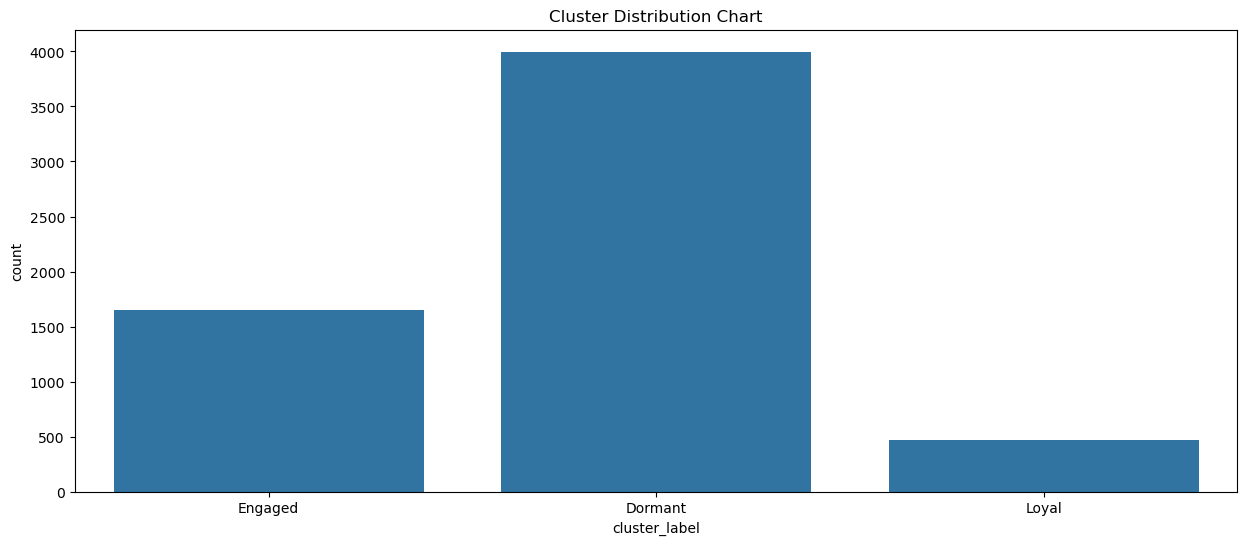

In [76]:
''' Visualizing the Cluster as a chart to determine the distribution of labels '''

plt.figure(figsize=(15,6))
sns.countplot(x='cluster_label', data=df_train)
plt.title('Cluster Distribution Chart')
plt.show()

# Recommendation System

In [78]:
original_df = pd.read_csv('recommend1.csv')

In [79]:
df_train.columns

Index(['jobma_catcher_id', 'org_type', 'jobma_catcher_industry',
       'jobma_catcher_type', 'is_premium', 'jobma_catcher_sub_accounts',
       'jobma_catcher_is_deleted', 'jobma_verified', 'subscription_status',
       'interview_rate', 'live_interview_credit', 'pre_recorded_credit',
       'credit_value', 'interview_cost_type', 'subscription_type_x',
       'jobma_support_rtc', 'interview_question', 'video_recording_suppport',
       'sing_up_canditate_after_apply', 'currency', 'company_size',
       'wallet_amount', 'plan_type', 'is_unlimited', 'premium_storage',
       'subscription_amount', 'number_of_subscriptions',
       'number_of_invitations', 'job_posted', 'number_of_kits', 'cluster_id',
       'cluster_label'],
      dtype='object')

In [80]:
df_train['subscription_status'].unique()

array([1, 2, 0], dtype=int64)

In [81]:
original_df.columns

Index(['jobma_catcher_id', 'jobma_catcher_company', 'company_size',
       'is_premium'],
      dtype='object')

In [100]:
def recommend(df, original_df, metric='wallet_amount', top_k=5, label='Loyal'):
    loyal_df = df[df['cluster_label'] == label]
    top_clients_df = loyal_df.sort_values(by=metric, ascending=False).head(top_k)
    merged_df = pd.merge(top_clients_df,
                         original_df[['jobma_catcher_id', 'jobma_catcher_company', 'company_size', 'is_premium']], 
                         on='jobma_catcher_id', 
                         how='left', 
                         suffixes=('_train', '_orig'))

    # columns_to_return = [col for col in ['jobma_catcher_id', 'jobma_catcher_company', 'company_size', 'is_premium'] if col in merged_df.columns]
    
    return merged_df[[
        'jobma_catcher_id',
        'jobma_catcher_company',
        'company_size_orig',
        'is_premium_orig'
    ]].rename(columns={
        'company_size_orig': 'company_size',
        'is_premium_orig'  : 'is_premium'
    })

In [111]:
original_df.columns

Index(['jobma_catcher_id', 'jobma_catcher_company', 'company_size',
       'is_premium'],
      dtype='object')

In [102]:
''' Loyal '''

result_loyal = recommend(df_train, original_df, metric='wallet_amount', top_k=5, label='Loyal')
print(result_loyal)

   jobma_catcher_id jobma_catcher_company company_size  is_premium
0              7099                qwerty         1-25         0.0
1              9577   Soyo NRI Enterprise      101-500         1.0
2              8518                   WAS      101-500         0.0
3              9724             Check.com     500-1000         0.0
4             10065     test User company         1-25         0.0


In [104]:
''' Engaged '''

result_engaged = recommend(df_train, original_df, metric='wallet_amount', top_k=5, label='Engaged')
print(result_engaged)

   jobma_catcher_id jobma_catcher_company    company_size  is_premium
0             10507          Sri infotech            1-25         0.0
1              8421    Testing LG and Co.         101-500         1.0
2              9792             NoCompany            1-25         0.0
3              8619          Sri Infotech  More than 1000         0.0
4              9781                jewvni            1-25         0.0


In [107]:
''' Dormant '''

result_dormant = recommend(df_train, original_df, metric='wallet_amount', top_k=5, label='Dormant')
print(result_dormant)

   jobma_catcher_id jobma_catcher_company company_size  is_premium
0              7556            Green Envi     500-1000         0.0
1              7517                 jobma         1-25         0.0
2              7704                   KWL      101-500         0.0
3              6437             PaperTest       26-100         1.0
4              7149                 jobma         1-25         0.0
